In [30]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import torch
import numpy as np
from models.ModularNetworks import PairwiseInteraction, Attention

from utils.couzin_utils import *
from utils.sim_utils import *
mpl.use('TkAgg')
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool, set_start_method
from utils.train_utils import compute_wasserstein_loss, gradient_penalty
from torch.utils.data import TensorDataset, DataLoader, random_split
from utils.encoder_utils import *
from ema_pytorch import EMA
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist
from tqdm.auto import tqdm

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
class Discriminator(nn.Module):
    def __init__(self, encoder, z_dim=32):
        super(Discriminator, self).__init__()
        self.encoder = encoder
        self.z_dim = z_dim
        self.input_dim = 2 * z_dim

        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def encoder_forward(self, tensor):
        states = tensor[..., :4]
        _, trans = self.encoder(states)
        batch, frames_minus_one, agent, neigh_rep = trans.shape
        feats = trans.reshape(batch * frames_minus_one * agent, neigh_rep)
        return feats, (batch, frames_minus_one, agent)

    def forward(self, tensor):
        features, shape = self.encoder_forward(tensor)
        batch, frames_minus_one, agent = shape

        params = torch.relu(self.fc1(features))
        params = torch.relu(self.fc2(params))
        params = torch.relu(self.fc3(params))
        params = self.fc4(params).squeeze(-1)

        params = params.view(batch, frames_minus_one, agent)
        scores = params.mean(dim=(1, 2))
        return scores

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp,
               noise=0, generation=None, num_generations=None):

        if noise > 0.0:
            noise_until = 0.5 * num_generations
            decay = 1.0 - (generation / noise_until)
            decay = max(0.0, decay)
            noise_term = noise * decay

            expert_batch = expert_batch.clone()
            policy_batch = policy_batch.clone()

            expert_batch = expert_batch + torch.randn_like(expert_batch) * noise_term 
            policy_batch = policy_batch + torch.randn_like(policy_batch) * noise_term

        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)

        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)

        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)

        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }

    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()


In [20]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [21]:
#https://github.com/yiftachbeer/mmd_loss_pytorch/blob/master/mmd_loss.py

class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.register_buffer(
            "bandwidth_multipliers",
            mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        )
        self.bandwidth = bandwidth
        
    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)
        return torch.as_tensor(self.bandwidth, device=L2_distances.device, dtype=L2_distances.dtype)

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, encoder, kernel=RBF()):
        super().__init__()
        self.encoder = encoder
        self.kernel = kernel

    def encode_transitions(self, tensor):
        states = tensor[..., :4]
        _, transitions = self.encoder(states)
        features = transitions.reshape(-1, transitions.size(-1))
        return features

    def forward(self, expert_batch, generative_batch):
        X = self.encode_transitions(expert_batch)
        Y = self.encode_transitions(generative_batch)

        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        mmd_loss = XX - 2 * XY + YY
        return mmd_loss

In [31]:
def plot_pca(transition_dim, role="prey"):
    scaler = StandardScaler()
    trans_fit = scaler.fit_transform(transition_dim)

    # PCA fit (alle Komponenten, damit Screeplot Sinn macht)
    pca = PCA(n_components=min(trans_fit.shape[0], trans_fit.shape[1]), random_state=0)
    X_pca = pca.fit_transform(trans_fit)

    expl = pca.explained_variance_ratio_
    cumexpl = np.cumsum(expl)

    # Components for 90% variance explanation
    k90 = int(np.searchsorted(cumexpl, 0.90) + 1)
    print("Components for 90% variance:", k90)

    x = np.arange(1, len(expl) + 1)

    plt.figure(figsize=(8, 4.5))
    plt.plot(x, expl, marker='o', label="Explained variance ratio")
    plt.plot(x, cumexpl, marker='o', label="Cumulative explained variance")
    plt.xlabel("Component")
    plt.ylabel("Variance")
    plt.title(f"[{role.upper()}] Scree Plot (PCA)")
    plt.ylim(0, 1.02)
    plt.legend()
    plt.tight_layout()
    plt.show()

    gmm = GaussianMixture(n_components=8, covariance_type="full", random_state=0)
    labels = gmm.fit_predict(X_pca)

    X_3d = X_pca[:, :3]

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, s=15)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("GMM Clusters in Transition Space (PCA11 → first 3 PCs)")

    plt.tight_layout()
    plt.show()


def gmm_cluster_count(transitions, pca_components=12, n_fits=20):
    pca = PCA(n_components=pca_components, random_state=0)
    X_pca = pca.fit_transform(transitions)

    aic_list = []
    bic_list = []

    for i in tqdm(range(n_fits)):
        gmm = GaussianMixture(n_components=i+1, covariance_type="full", random_state=0)
        gmm.fit(X_pca)

        aic = gmm.aic(X_pca)
        bic = gmm.bic(X_pca)

        aic_list.append(aic)
        bic_list.append(bic)

    ks = np.arange(1, n_fits + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(ks, aic_list, marker="o", label="AIC")
    plt.plot(ks, bic_list, marker="o", label="BIC")
    plt.xlabel("Number of GMM components")
    plt.ylabel("Information criterion")
    plt.title(f"GMM model selection")
    plt.legend()
    plt.tight_layout()
    plt.show()


def calculate_cluster_metrics(model, pca_fit, labels):
    db = davies_bouldin_score(pca_fit, labels)
    print("Davies–Bouldin:", db)

    ch = calinski_harabasz_score(pca_fit, labels)
    print("Calinski–Harabasz:", ch)

    ll = model.score(pca_fit)   # mean log-likelihood
    print("Avg log-likelihood:", ll)

    probs = model.predict_proba(pca_fit)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    print("Mean entropy:", entropy.mean())

    counts = np.bincount(labels)
    freqs = counts / counts.sum()
    print("Cluster frequencies:", freqs)
    print("Std of frequencies:", freqs.std())

    centers = model.means_
    center_dists = pdist(centers)
    print("Mean center distance:", center_dists.mean())

In [23]:
def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations,
                      rel_clip=0.01, abs_clip=None, min_clip=1e-12):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward

    delta = (lr / (2 * sigma**2 * num_perturbations)) * grad

    theta_norm = theta.norm()
    max_delta_norm = rel_clip * theta_norm

    if abs_clip is not None:
        max_delta_norm = torch.minimum(max_delta_norm, theta.new_tensor(abs_clip))

    max_delta_norm = torch.maximum(max_delta_norm, theta.new_tensor(min_clip))

    dn = delta.norm() + 1e-12
    clip_ratio = (max_delta_norm / dn).clamp(max=1.0)
    delta = delta * clip_ratio

    return theta + delta


def discriminator_reward(discriminator, gen_tensor):
    scores = discriminator(gen_tensor)
    return scores.mean()


def optimize_es(policy, module, discriminator, lr, sigma, num_perturbations):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    device = next(policy.parameters()).device
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()

    seeds = np.random.randint(0, 100000, size=num_perturbations)

    reward_diffs = []
    epsilons = []

    disc_device = next(discriminator.parameters()).device

    for perturbation in range(num_perturbations):

        seed = seeds[perturbation]

        eps = torch.randn(dim, device=theta.device, dtype=theta.dtype) * sigma
        epsilons.append(eps)

        with torch.no_grad():
            nn.utils.vector_to_parameters(theta + eps, network.parameters())
            _, pos_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, device=device)
            pos_prey_tensor = pos_prey_tensor.unsqueeze(0).to(device=disc_device)
            pos_reward = discriminator_reward(discriminator, pos_prey_tensor)

            nn.utils.vector_to_parameters(theta - eps, network.parameters())
            _, neg_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, device=device)
            neg_prey_tensor = neg_prey_tensor.unsqueeze(0).to(device=disc_device)
            neg_reward = discriminator_reward(discriminator, neg_prey_tensor)

            nn.utils.vector_to_parameters(theta, network.parameters())

            reward_diffs.append((pos_reward.mean() - neg_reward.mean()).detach())

    diffs = torch.stack(reward_diffs).to(theta.device)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)

    # if std is too small, do not update (Random Walk)
    if diffs.std(unbiased=False) < 1e-6:
        theta_est = theta

    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {"diff_min": round(diffs.min().item(), 6),
            "diff_max": round(diffs.max().item(), 6),
            "diff_mean": round(diffs.mean().item(), 6),
            "diff_std": round(diffs.std(unbiased=False).item(), 6),
            "delta_norm": round((theta_est - theta).norm().item(), 6)}


def mae_actions(expert_batch, generative_batch):
    a_exp = expert_batch[..., 4]
    a_gen = generative_batch[..., 4]
    return torch.mean(torch.abs(a_exp - a_gen)).item()


def pretrain_policy(policy, expert_data, batch_size=256, epochs=250, lr=1e-3, deterministic=True, device='cpu'):
    policy.to(device)
    policy.train()

    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    frames, agents, neigh, features = expert_data.shape
    expert_data = expert_data.reshape(frames * agents, neigh, features)
    
    states = expert_data[..., :4]
    actions = expert_data[:, 0, 4]

    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for s, a in loader:
            states = s.to(device)
            actions = a.to(device)

            action = policy.forward(states, deterministic=deterministic)

            if action.dim() == 2 and action.size(-1) == 1:
                action = action.squeeze(-1) 

            loss = F.mse_loss(action, actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * a.size(0)

        if epoch % 25 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / (frames * agents):.6f}")

    return policy

In [24]:
# Training
num_generations = 800
gamma = 0.999

# Policy
lr_policy = 0.001
num_perturbations = 32
sigma = 0.15
deterministic=True

# Discriminator
dis_balance_factor = 5
noise = 0.01
lr_disc = 0.0001
lambda_gp = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'
init_pool_path = rf'..\data\1. Data Processing\processed\init_pool'

pred_files = []
prey_files = []

for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32).to(device)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32).to(device)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


In [26]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=1500, optimizer=prey_optimizer, role="prey")

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=1000, optimizer=pred_optimizer, role="predator")

for p in pred_encoder.parameters():
    p.requires_grad = False

print("Predator Encoder trained & frozen.")

epoch 010: loss=22.900726 sim=0.0465 std=1.3275 cov=0.3652 std_mean=0.336
epoch 020: loss=21.943127 sim=0.0355 std=1.2605 cov=0.4295 std_mean=0.370
epoch 030: loss=21.665754 sim=0.0397 std=1.2504 cov=0.3837 std_mean=0.375
epoch 040: loss=20.904722 sim=0.0349 std=1.1758 cov=0.4791 std_mean=0.412
epoch 050: loss=20.396320 sim=0.0380 std=1.1453 cov=0.4535 std_mean=0.427
epoch 060: loss=19.984291 sim=0.0376 std=1.0937 cov=0.5279 std_mean=0.453
epoch 070: loss=20.148689 sim=0.0430 std=1.0578 cov=0.6415 std_mean=0.471
epoch 080: loss=19.596067 sim=0.0442 std=1.0623 cov=0.5112 std_mean=0.469
epoch 090: loss=19.280106 sim=0.0435 std=1.0455 cov=0.5020 std_mean=0.477
epoch 100: loss=19.215097 sim=0.0430 std=1.0193 cov=0.5701 std_mean=0.490
epoch 110: loss=18.857424 sim=0.0451 std=1.0066 cov=0.5264 std_mean=0.497
epoch 120: loss=18.793959 sim=0.0471 std=0.9702 cov=0.6126 std_mean=0.515
epoch 130: loss=18.528582 sim=0.0465 std=0.9778 cov=0.5398 std_mean=0.511
epoch 140: loss=18.682199 sim=0.0471 s

In [27]:
scaler = StandardScaler()
prey_states = exp_prey_tensor[..., :5]
_, trans_prey = prey_encoder(prey_states)
x_prey = trans_prey.detach().cpu().numpy()
prey_trans_dim = x_prey.reshape(-1, x_prey.shape[-1])
scaled_prey = scaler.fit_transform(prey_trans_dim)

pred_states = exp_pred_tensor[..., :4]
_, trans_pred = pred_encoder(pred_states)
x_pred = trans_pred.detach().cpu().numpy()
pred_trans_dim = x_pred.reshape(-1, x_pred.shape[-1])  
scaled_pred = scaler.fit_transform(pred_trans_dim)

Components for 90% variance: 11


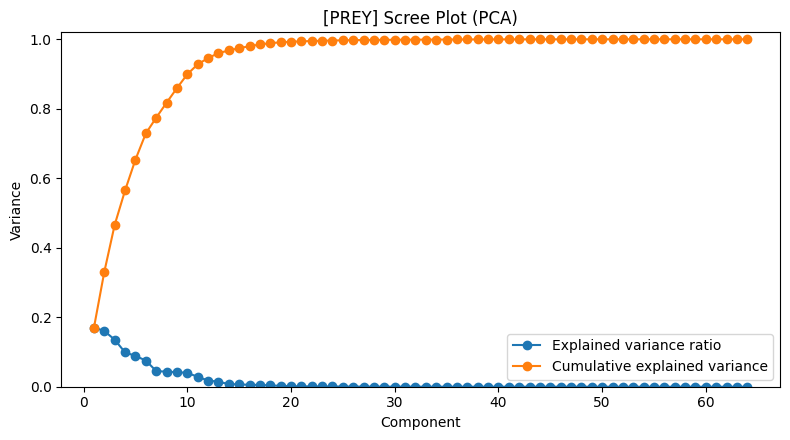

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


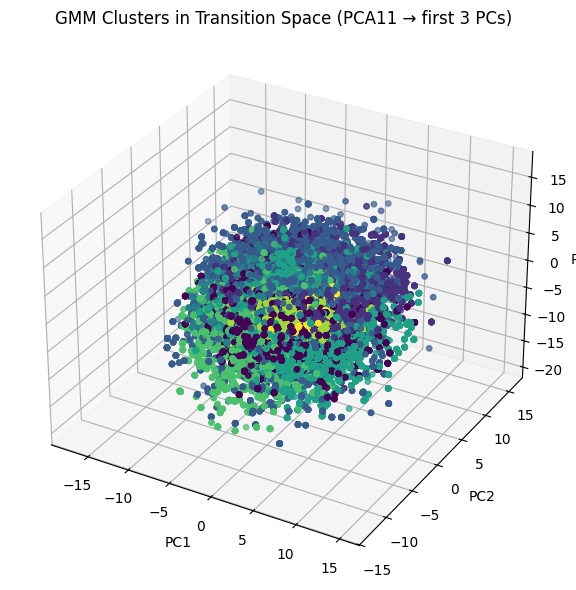

In [28]:
plot_pca(prey_trans_dim, role="prey")

In [ ]:
gmm_cluster_count(scaled_prey, pca_components=11, n_fits=20)

 50%|█████     | 10/20 [01:19<02:01, 12.10s/it]

In [ ]:
pca = PCA(n_components=12, random_state=0)
X_pca = pca.fit_transform(scaled_prey)

gmm = GaussianMixture(n_components=10, covariance_type="full", random_state=0)
labels = gmm.fit(X_pca)

calculate_cluster_metrics(gmm, X_pca, labels)

Components for 90% variance: 9


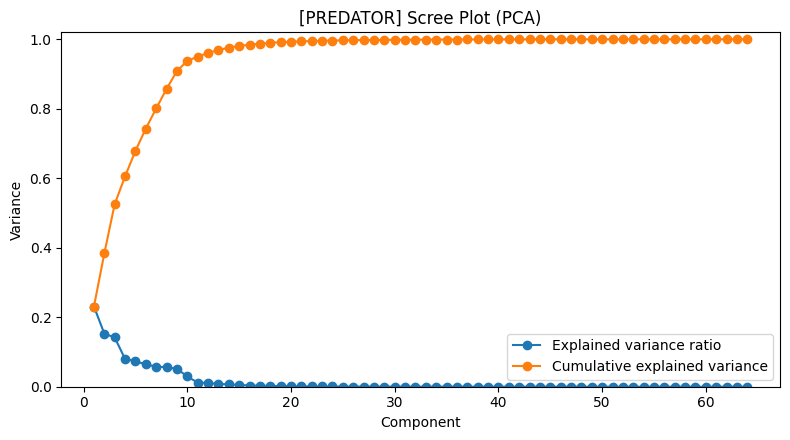

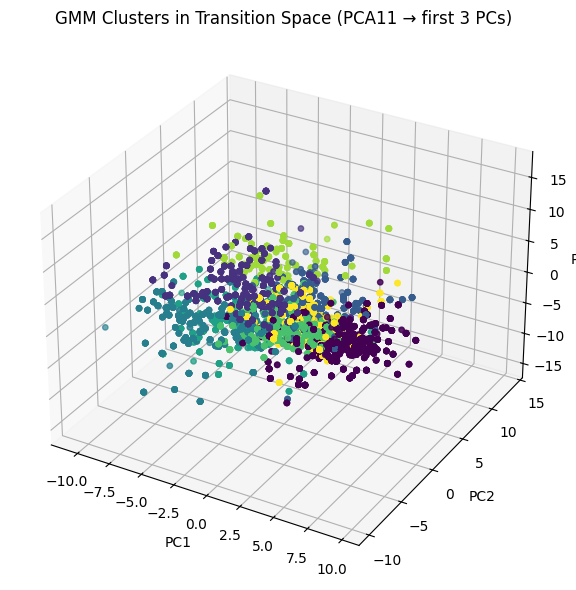

In [15]:
plot_pca(pred_trans_dim, role="predator")

In [ ]:
gmm_cluster_count(scaled_pred, pca_components=9, n_fits=20)

In [ ]:
pca = PCA(n_components=9, random_state=0)
X_pca = pca.fit_transform(scaled_pred)

gmm = GaussianMixture(n_components=10, covariance_type="full", random_state=0)
labels = gmm.fit(X_pca)

calculate_cluster_metrics(gmm, X_pca, labels)